In [66]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [101]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=282
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147
nipd=int((et-st)/Bin_size)-irows-orows+1

In [102]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_n&f.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_n&f.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [103]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [104]:
print(irows,orows)

3 1


In [109]:
# Dataset looks good here
def giveme_dataset(rows,cols):
    for i in range(1,rows+1):
        print(dataset[i][:cols])
giveme_dataset(3,3)

[0.         0.01865434 0.10891486]
[0.13697164 0.23473744 0.22698761]
[0.12185569 0.05441312 0.03356269]


In [110]:
#Fixing number of clusters:
nclust=4

#Selecting correlated columns based on cluster number
if nclust==5:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_5branch.csv',header =None)
if nclust==4:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_4branch.csv',header =None)
if nclust==3:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_3branch.csv',header =None)    
if nclust==2:
    df_clust = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Tree_2branch.csv',header =None)
index_ps=df_clust[1]

#Creating a list of columns to consider for each model
cols2consider=[]
for i in range(nclust):
    cols2consider.append([])

#Appending values to cols2consider
for i in range(1,len(index_ps)):
    bloc=int(index_ps[i])
    cols2consider[bloc-1].append(i)
    
# Note: Here, in elements of cols2consider, segments start from 1 and go till 280.
# but while indexing in dataset, it should start from 0 therefore we subtract 1 
# from elements in cols2consider
c2c_copy=cols2consider
cols2consider=[]
for ar in c2c_copy:
    cols2consider.append([k-1 for k in ar])

if cols2consider[0]==[k-1 for k in c2c_copy[0]]:
    print("Unit Subraction from cols2consider complete! \n")
else:
    print("ERROR: Something wrong with subraction! \n")

#Check if everything is fine
index_l=index_ps.tolist()      # converting pandas series to list
if index_l.count('1')==len(cols2consider[0]) and (len(cols2consider[nclust-1])==index_l.count(str(nclust))):
    print("Good to go! Cols2consider seems good..")

Unit Subraction from cols2consider complete! 

Good to go! Cols2consider seems good..


In [111]:
len(cols2consider[0])+len(cols2consider[1])+len(cols2consider[2])+len(cols2consider[3])

280

In [112]:
# Function to check a X,y pair and look at the lengths:
def verify_io(Xi,yi,info,i):
    if info==True:
        print("Number of X matrices:",len(Xi))
        print("Number of y matrices:",len(yi))
        print("Number i/o pairs expected:",(rows_pday-irows-orows+1)*34)
    elif(len(Xi)==len(yi)==(rows_pday-irows-orows+1)*34):
        print("Number of i/o pairs is as expected!")
    else:
        print("ERROR: Number of i/o pairs is not as expected!")
    if info==True:
        print("Number of features in each X matrix:",len(Xi[0][1]))
        print("Number of features in each y matrix:",len(yi[0]))
        print("Number of features expected:",len(cols2consider[i])+2,"for X")
    elif(len(Xi[0][1])-2==len(yi[0])==len(cols2consider[i])):
        print("Number of features is as expected!")
    else:
        print("ERROR: Number of features is not as expected!")

In [139]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# Create a list of X and y to put in X and y for different groups.
yl=[]
for i in range(nclust):
    yl.append([])
Xl=[]
for i in range(nclust):
    Xl.append([])

#Split sequences according to group number given:
def split_sequences_by_grp(sequences, n_steps_in, n_steps_out,grp_no): # Grp no should start from 0
    for i in range(len(sequences)):
        # Find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # Select columns depending on grouping and adding Weekday and Hour data
        ysel_col=[ji for ji in cols2consider[grp_no]]
        Xsel_col=[ja for ja in cols2consider[grp_no]]
        Xsel_col.append(280)
        Xsel_col.append(281)
        #print("Xsel_col=",Xsel_col)
        #print("ysel_col=",ysel_col)
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,Xsel_col], sequences[end_ix:out_end_ix,ysel_col][0]
        #print("Seq_x",seq_x)
        #print("Seq_y",seq_y)
        Xl[grp_no].append(seq_x)
        yl[grp_no].append(seq_y)
    if len(seq_x[0])!= len(seq_y)+2:
        print("ERROR: column selection wrong!")
    return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# Convert into input/output
# Need to change to 34 or 35 or whatever when nrows in dataset change
#i=1
for i in range(1,35):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    for j in range(nclust):
         #print("\n\nFor group:",j)
# k=np.asarray([i for i in range(1,100*20+1)])
# k1=k.reshape(20,100)
        split_sequences_by_grp(todays_df, n_steps_in, n_steps_out,j)


In [147]:
#This
yl[0][2]

array([0.51484876, 0.38869066, 0.26400687, 0.15547151, 0.37874471,
       0.22215605, 0.28416143, 0.55939605, 0.63842087, 0.56784209,
       0.39452182, 0.25072114, 0.27840254, 0.30507958, 0.29781677,
       0.55703314, 0.39553329, 0.46972595, 0.62880497, 0.26116789,
       0.46120352, 0.3553907 , 0.23528543, 0.48358584, 0.35772133,
       0.5375267 , 0.42815704, 0.51061134, 0.46233389, 0.545437  ,
       0.48670889, 0.56373214, 0.38952487, 0.53994075, 0.27584792,
       0.43435522, 0.23350417, 0.46261133, 0.29118934, 0.40812769,
       0.43579708, 0.49699324, 0.60511491, 0.49409514, 0.38815845,
       0.37068872, 0.0717713 , 0.12283145, 0.57864332, 0.25144934,
       0.37666975, 0.28090641, 0.11572088, 0.30940143, 0.07872083,
       0.34727047, 0.3551827 , 0.26870468, 0.47488975, 0.25565278,
       0.47368468, 0.0407128 , 0.06394164, 0.41618481, 0.58317546,
       0.33802439, 0.29600153, 0.42909754])

In [142]:
#Check if the matrix are created properly:
verify_io(Xl[0],yl[0],True,0)
verify_io(Xl[1],yl[1],False,1)
verify_io(Xl[2],yl[2],False,2)
verify_io(Xl[3],yl[3],False,3)

Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X
Number of i/o pairs is as expected!
Number of features is as expected!
Number of i/o pairs is as expected!
Number of features is as expected!
Number of i/o pairs is as expected!
Number of features is as expected!


In [148]:
def giveme_y(rows,cols):
    for i in range(0,rows+1):
        print(yl[0][i][:cols])
giveme_y(3,3)

[0.06791322 0.33685298 0.34324812]
[0.35811766 0.52902932 0.42222478]
[0.51484876 0.38869066 0.26400687]
[0.25059284 0.333912   0.2502424 ]


In [149]:
irows,orows

(3, 1)

In [150]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np

# #Function to check if all the NA matrices are deleted.
def check_NA(X_fil,y_fil,Name):
    Na_count=0
    for i in range(len(X_fil)):
        if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
            Na_count=Na_count+1
    if Na_count==0:
        print("Na Matrices filtered out sucessfuly in",Name,"!")
    else:
        print("ERROR: NA value found!")
        
#Function to filter the NA matrices.
def filter_NA(X_o,y_o):
    X_fil=np.array(X_o)
    y_fil=np.array(y_o)
    del_index=[]
    # Noting down the index of Na matrices in del_index 
    for i in range(len(X_fil)):
        del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))
    # Filtering out the Na matrices from y_fil and X_fil by indexing using a list
    y_fil=y_fil[list(~np.array(del_index))]
    X_fil=X_fil[list(~np.array(del_index))]
    return X_fil,y_fil

X1,y1=filter_NA(Xl[0],yl[0])
X2,y2=filter_NA(Xl[1],yl[1])
X3,y3=filter_NA(Xl[2],yl[2])
X4,y4=filter_NA(Xl[3],yl[3])

check_NA(X1,y1,"G1")
check_NA(X2,y2,"G2")
check_NA(X2,y2,"G3")
check_NA(X2,y2,"G4")

Na Matrices filtered out sucessfuly in G1 !
Na Matrices filtered out sucessfuly in G2 !
Na Matrices filtered out sucessfuly in G3 !
Na Matrices filtered out sucessfuly in G4 !


In [151]:
giveme_y(3,3)

[0.06791322 0.33685298 0.34324812]
[0.35811766 0.52902932 0.42222478]
[0.51484876 0.38869066 0.26400687]
[0.25059284 0.333912   0.2502424 ]


In [152]:
# Print number of IO Pairs available:
print(len(y4)," I/O pairs available")
verify_io(X1,y1,True,0)

510  I/O pairs available
Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


In [153]:
# Function to Flatten output
verify_io(Xl[0],yl[0],True,0)

# Note: No need to flatten output as y already has only 2 dimensions.
y1.shape
# def Flatten_output(y_il):
#     n_output = y_il.shape[1] * y_il.shape[2]
#     return y_il.reshape((y_il.shape[0], n_output))

# print(y1)
# y1=Flatten_output(y1)
# y2=Flatten_output(y2)
# y3=Flatten_output(y3)
# y4=Flatten_output(y4)

Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(510, 68)

In [154]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [155]:
verify_io(X1,y1,True,0)
X1.shape

Number of X matrices: 510
Number of y matrices: 510
Number i/o pairs expected: 510
Number of features in each X matrix: 70
Number of features in each y matrix: 68
Number of features expected: 70 for X


(510, 3, 70)

In [156]:
len(X1),len(X2),len(X3),len(X4)

(510, 510, 510, 510)

In [157]:
# Splitting into train and test sets randomly
# np.random.seed(95)
# msk = np.random.rand(len(X_fil)) < 0.8

#Splitting taking the last 7days as the test set:
#Change this if day number changes
test_size=7
train_end=(34-test_size)*(rows_pday-irows-orows+1)
msk=[]
for i in range(34*(rows_pday-irows-orows+1)):
    if i<=train_end:
        msk.append(True)
    else:
        msk.append(False)
msk=np.asarray(msk)

In [158]:
# Splitting into train and test sets
# np.random.seed(95)
# msk = np.random.rand(len(X1)) < 0.8
X_train = X1[msk]
y_train = y1[msk]
X_test = X1[~msk]
y_test = y1[~msk]
print("Dataset splitting done! for Grp-1")

#Verify shape once:
#verify_io(X_test,y_test,False,0)


n_output=len(y_train[0])
n_colx=len(X1[0][0])

# multivariate output multi-step 1d cnn example

# define model
model1 = Sequential()
model1.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(500, activation='relu'))
model1.add(Dense(n_output))
model1.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model1.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-1 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model1.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model1.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model1.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-1
Group-1 ; Model-3 

Number or epochs: 12
Number of input features: 70
Number of output features: 68
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 406
Number of I/O pairs available for testing: 104
104/104 [==============================] - 0s 57us/step
Model Mape loss: 2619902.735576923
104/104 [==============================] - 0s 88us/step
Model MSE loss (Minimized): 0.03841053809110935
104/104 [==============================] - 0s 103us/step
RMSE loss: 0.19598606606366012


In [167]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.20083781 0.46544411 0.24597875]
[0.22675959 0.50208535 0.14565598]
[0.18726386 0.47034024 0.13260803]
[0.28267543 0.56848034 0.18880468]


In [168]:
# Splitting into train and test sets
#np.random.seed(95)
#msk = np.random.rand(len(X2)) < 0.8
X_train = X2[msk]
y_train = y2[msk]
X_test = X2[~msk]
y_test = y2[~msk]
print("Dataset splitting done! for Grp-2\n")

#Verify shape once:
verify_io(X_train,y_train,True,1)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(500, activation='relu'))
model2.add(Dense(n_output))
model2.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model2.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-2 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model2.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model2.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model2.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-2

Number of X matrices: 406
Number of y matrices: 406
Number i/o pairs expected: 510
Number of features in each X matrix: 44
Number of features in each y matrix: 42
Number of features expected: 44 for X
Group-2 ; Model-3 

Number or epochs: 12
Number of input features: 44
Number of output features: 42
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 406
Number of I/O pairs available for testing: 104
104/104 [==============================] - 0s 64us/step
Model Mape loss: 5995108.692307692
104/104 [==============================] - 0s 79us/step
Model MSE loss (Minimized): 0.03771251268111742
104/104 [==============================] - 0s 58us/step
RMSE loss: 0.19419709750950817


In [169]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.52137706 0.39593718 0.36645147]
[0.59118484 0.59280288 0.5789552 ]
[0.45430397 0.48698881 0.80551811]
[0.37559192 0.34580258 0.33377962]


In [170]:
# Splitting into train and test sets
#np.random.seed(95)
#msk = np.random.rand(len(X3)) < 0.8
X_train = X3[msk]
y_train = y3[msk]
X_test = X3[~msk]
y_test = y3[~msk]
print("Dataset splitting done! for Grp-3\n")

#Verify shape once:
verify_io(X_train,y_train,True,2)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Flatten())
model3.add(Dense(500, activation='relu'))
model3.add(Dense(n_output))
model3.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model3.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-3 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model3.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model3.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model3.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-3

Number of X matrices: 406
Number of y matrices: 406
Number i/o pairs expected: 510
Number of features in each X matrix: 31
Number of features in each y matrix: 29
Number of features expected: 31 for X
Group-3 ; Model-3 

Number or epochs: 12
Number of input features: 31
Number of output features: 29
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 406
Number of I/O pairs available for testing: 104
104/104 [==============================] - 0s 61us/step
Model Mape loss: 2240801.898777888
104/104 [==============================] - 0s 72us/step
Model MSE loss (Minimized): 0.03768666031268927
104/104 [==============================] - 0s 90us/step
RMSE loss: 0.1941305239077288


In [171]:
# Splitting into train and test sets
#np.random.seed(95)
#msk = np.random.rand(len(X4)) < 0.8
X_train = X4[msk]
y_train = y4[msk]
X_test = X4[~msk]
y_test = y4[~msk]
print("Dataset splitting done! for Grp-4\n")

#Verify shape once:
verify_io(X_train,y_train,True,3)


n_output=len(y_train[0])
n_colx=len(X_train[0][0])

# multivariate output multi-step 1d cnn example

# define model
model4 = Sequential()
model4.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_colx)))
model4.add(MaxPooling1D(pool_size=2))
model4.add(Flatten())
model4.add(Dense(500, activation='relu'))
model4.add(Dense(n_output))
model4.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12

# fit model
history=model4.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Group-4 ; Model-3 \n")
print("Number or epochs:",epochno)
print("Number of input features:",n_colx)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available for training:",len(y_train))
print("Number of I/O pairs available for testing:",len(y_test))
print("Model Mape loss:",model4.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model4.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model4.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

Dataset splitting done! for Grp-4

Number of X matrices: 406
Number of y matrices: 406
Number i/o pairs expected: 510
Number of features in each X matrix: 143
Number of features in each y matrix: 141
Number of features expected: 143 for X
Group-4 ; Model-3 

Number or epochs: 12
Number of input features: 143
Number of output features: 141
Bin size: 1
Window size: 3
Number of I/O pairs available for training: 406
Number of I/O pairs available for testing: 104
104/104 [==============================] - 0s 68us/step
Model Mape loss: 1993782.3935834444
104/104 [==============================] - 0s 73us/step
Model MSE loss (Minimized): 0.03379194839642598
104/104 [==============================] - 0s 89us/step
RMSE loss: 0.183825864329332


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


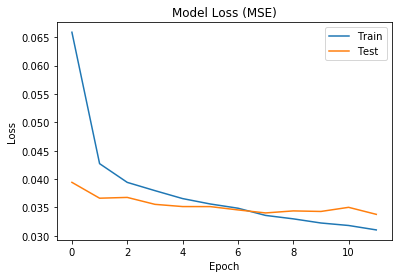

In [172]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [85]:
X1[0][0]

array([0.        , 0.01865434, 0.10891486, 0.18354451, 0.17191932,
       0.16565897, 0.43818386, 0.28296556, 1.        , 1.        ,
       1.        , 1.        , 0.12230949, 0.20450941, 0.26685608,
       0.52618939, 0.17668065, 0.09829099, 0.40513264, 0.14483435,
       0.25570204, 0.73522276, 1.        , 0.05360666, 0.10901715,
       0.06669544, 0.0287042 , 0.05624088, 0.07337318, 0.11567154,
       0.31129467, 0.32806198, 0.21255732, 0.81411288, 0.24779593,
       0.00412964, 0.14676671, 0.04395396, 0.26760511, 0.26948608,
       0.20623002, 0.23243357, 0.07792963, 0.09626329, 0.4059496 ,
       0.33097558, 0.07663274, 0.17851208, 0.3411316 , 0.07066831,
       0.2595229 , 0.01495825, 0.0278979 , 0.03242596, 0.        ,
       0.541451  , 0.04862106, 0.        , 0.01385192, 0.1833435 ,
       0.0140338 , 0.00567093, 0.38649259, 1.        , 0.        ,
       0.        , 0.28474235, 0.        , 0.        , 0.0480427 ])

In [173]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [174]:
X1[~msk].shape

(104, 3, 70)

In [175]:
orderlist

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 23,
 24,
 41,
 42,
 54,
 55,
 56,
 57,
 63,
 64,
 70,
 71,
 87,
 88,
 89,
 101,
 105,
 106,
 114,
 115,
 132,
 133,
 138,
 139,
 146,
 147,
 148,
 160,
 161,
 169,
 170,
 171,
 172,
 176,
 177,
 186,
 188,
 191,
 192,
 197,
 200,
 201,
 206,
 209,
 210,
 225,
 232,
 234,
 235,
 236,
 256,
 262,
 266,
 7,
 8,
 9,
 10,
 11,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 109,
 110,
 111,
 112,
 12,
 18,
 22,
 40,
 53,
 62,
 69,
 86,
 99,
 100,
 104,
 113,
 131,
 145,
 159,
 167,
 168,
 175,
 187,
 196,
 199,
 204,
 205,
 208,
 224,
 233,
 255,
 261,
 265,
 52,
 58,
 59,
 60,
 61,
 65,
 66,
 67,
 68,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 102,
 103,
 107,
 108,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 134,
 135,
 136,
 137,


In [187]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(98)

#Defining order list
orderlist=[]
for grp in cols2consider:
        orderlist=orderlist+grp

# Define a function that returns the segment if a touple in the fom (index in list,tt) is given
def tellme_seg(tu):
    return orderlist[tu[0]]

# Defining a function to map travel times to the segments
def arrange_tt_by_seg(tlist):
    touple_list=[(i,tlist[i]) for i in range(len(tlist))]
    touple_list.sort(key=tellme_seg)
    sorted_tp_list=touple_list
    arranged_tt=[el[1] for el in sorted_tp_list]
    return arranged_tt

#Function to return arranged and normalized 
def get_pdt_and_act(obs):
    
    #Reshaping input to be suitable for the observation
    x1_input = X1[~msk][obs].reshape((1, W_size, len(X1[0][0])))
    x2_input = X2[~msk][obs].reshape((1, W_size, len(X2[0][0])))
    x3_input = X3[~msk][obs].reshape((1, W_size, len(X3[0][0])))
    x4_input = X4[~msk][obs].reshape((1, W_size, len(X4[0][0])))
    
    #Predicting values for each group for rnd observation
    g1_yp=model1.predict(x1_input, verbose=0)
    g2_yp=model2.predict(x2_input, verbose=0)
    g3_yp=model3.predict(x3_input, verbose=0)
    g4_yp=model4.predict(x4_input, verbose=0)

    #Getting the real value for each group for the rnd
    g1_ya=y1[~msk][obs]
    g2_ya=y2[~msk][obs]
    g3_ya=y3[~msk][obs]
    g4_ya=y4[~msk][obs]
    
    tt_list_ya=list(g1_ya)+list(g2_ya)+list(g3_ya)+list(g4_ya)
    tt_list_yp=list(g1_yp[0])+list(g2_yp[0])+list(g3_yp[0])+list(g4_yp[0])
    
    act=arrange_tt_by_seg(tt_list_ya)
    pdt=arrange_tt_by_seg(tt_list_yp)
    
    return pdt,act

pdt_1,act_1=get_pdt_and_act(2)

#print(type(g1_ya.shape),"\n\n")
#print(len(yhat[0]))
# pdt=yhat[0]
# act=y_output
# if len(pdt)==len(act):
#     print("Lengths match good to go!")

In [188]:
def giveme_ytest(rows,cols):
    for i in range(0,rows+1):
        print(y_test[i][:cols])
giveme_ytest(3,3)

[0.28356101 0.50250905 0.43128462]
[0.45137143 0.3397505  0.2888186 ]
[0.27907351 0.23940181 0.24288811]
[0.49906565 0.21410657 0.21686101]


In [186]:
act_1

[0.18726385602313803,
 0.47034024096674204,
 0.132608028059884,
 0.18145204393133105,
 0.636882611257088,
 0.6013526392772309,
 0.32364572197377695,
 0.45430397393004107,
 0.486988810600674,
 0.8055181099177379,
 0.944956427933226,
 0.802168876553088,
 0.7700790246058,
 0.32144564458592895,
 0.5729494352079879,
 0.649977149204697,
 0.8264911575558042,
 0.7883332480306859,
 0.6669565641871821,
 0.27844553154507895,
 0.38769561338074604,
 0.277662976676116,
 0.45534883497824297,
 0.535804254198907,
 0.214581715305892,
 0.3622413756507629,
 0.351118180125314,
 0.452308658580845,
 0.412423381697101,
 0.35952767567472993,
 0.45127440647695205,
 0.47904461917668895,
 0.435927656716857,
 0.41304012383616706,
 0.37459373392512,
 0.34027898417409,
 0.350410464399552,
 0.39794180265612294,
 0.377145675097591,
 0.37689570872959494,
 0.5378663561507511,
 0.617919031981492,
 0.657439474067044,
 0.546295880884656,
 0.38686934354775504,
 0.41940870958054,
 0.39164101211654795,
 0.178538143396235,
 0.

In [189]:
# Just python refreshment
#chin=np.asarray([i for i in range(280
#chin.reshape((1,W_size,70))

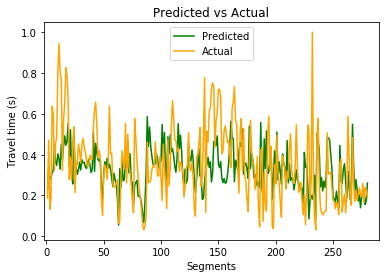

In [190]:
import matplotlib.pyplot as plt
import numpy

#Function to plot any two values:
def plot_this(predicted,actual):
    x=list(range(1,len(predicted)+1))
    plt.plot(x, predicted[0:], color='g',label="Predicted")
    plt.plot(x, actual[0:], color='orange',label="Actual")
    plt.xlabel('Segments')
    plt.ylabel('Travel time (s)')
    plt.title('Predicted vs Actual')
    axes = plt.gca()
    #axes.set_ylim([0,180])
    axes.set_xlim([-2,len(predicted)+10])
    leg = plt.legend();
    plt.show()
plot_this(pdt_1,act_1)

In [191]:
#Scaling the IO values and then determining MSE and shit
import pandas as pd

# Selecting data min-max data
Minmax = pd.read_csv('/home/pennyworth/Documents/Bus/Data/Minmax.csv')


In [192]:
# Just to eyeball data
Minmax.drop(["V281"],axis=1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280
0,144.393008,115.714823,42.493365,24.211194,20.792030,31.301400,15.261249,11.463829,10.438957,10.160103,...,16.602995,14.777967,13.615912,14.194309,13.784148,15.715016,15.611628,16.334124,23.636502,32.203997
1,21.743496,27.824041,12.590967,10.181975,9.777823,10.144633,8.673208,7.440940,6.730975,6.393548,...,6.540165,6.273787,6.223952,6.223956,6.212245,6.268387,6.356335,6.478718,6.811262,7.332060


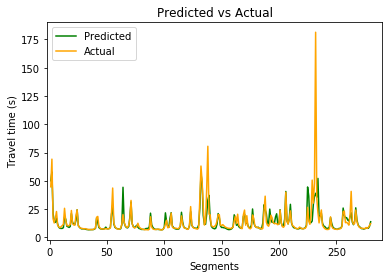

In [194]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_pred,y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# To denormalize
def denormalize_pdt_act(nor_pdt,nor_act):
    pdt_cor=[i for i in range(280)]
    act_cor=[i for i in range(280)]
    i=0
    for col in Minmax.drop(["V281"],axis=1):
        mn=Minmax[col][1]
        mx=Minmax[col][0]
        pdt_cor[i]=(nor_pdt[i]*(mx - mn))+mn
        act_cor[i]=(nor_act[i]*(mx - mn))+mn
        i=i+1
    return pdt_cor,act_cor

P,A=denormalize_pdt_act(pdt_1,act_1)
plot_this(P,A)

In [196]:
import matplotlib.pyplot as plt
import numpy

#function to get errror for any pdt and act
def get_error_pdt_act(pdt_err,act_err,printing=False):
    if printing==True:
        print("MSE Error:",mean_squared_error(pdt_err,act_err))
        print("RMSE Error:",np.sqrt(mean_squared_error(pdt_err,act_err)))
        print("MAPE Error:",mean_absolute_percentage_error(pdt_err,act_err))
    mse=mean_squared_error(pdt_err,act_err)
    rmse=np.sqrt(mean_squared_error(pdt_err,act_err))
    mape=mean_absolute_percentage_error(pdt_err,act_err)
    return mse,rmse,mape

get_error_pdt_act(P,A,False) 


(105.53639990925399, 10.27309105913376, 14.446374235539741)

In [197]:
#Iterating over all tensors in test set

#Check if lengths match:
if X1.shape[0]==y1.shape[0]==X2.shape[0]:
    print("Good to go!")
else:
    print("Lengths dont match!")

MSE_list=[]
RMSE_list=[]
MAPE_list=[]
pdt_list=[]
act_list=[]


total_test=X1[~msk].shape[0]
for ind in range(total_test):
    norm_pdt,norm_act=get_pdt_and_act(ind)
    denorm_pdt,denorm_act=denormalize_pdt_act(norm_pdt,norm_act)
    pdt_list.append(denorm_pdt)
    act_list.append(denorm_act)
    MSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[0])
    RMSE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[1])
    MAPE_list.append(get_error_pdt_act(denorm_pdt,denorm_act)[2])

mean_MSE=sum(MSE_list)/len(MSE_list)
mean_RMSE=sum(RMSE_list)/len(RMSE_list)
mean_MAPE=sum(MAPE_list)/len(MAPE_list)    

print("\n")
print("Model - 3")

print("Overall MSE",mean_MSE)
print("Overall RMSE",mean_RMSE)
print("Overall MAPE",mean_MAPE)

Good to go!


Model - 3
Overall MSE 43.70746085309494
Overall RMSE 6.303040151202656
Overall MAPE 18.567470278156073


In [198]:
X1[~msk].shape[0]

104

In [199]:
# Creating a dataframe out of the tt lists
predicted_df=pd.DataFrame(pdt_list)
actual_df=pd.DataFrame(act_list)

In [200]:
#Saving the dataframes as csv tables.
predicted_df.to_csv("Model3_pdt.csv")
actual_df.to_csv("Model3_act.csv")